## Polynomial Regression with Regularisation (Lasso and Ridge)

### Data Preprocessing 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import time
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn")

### Retrieveing Data

In [2]:
df=pd.read_csv("./insurance.txt")
df = df.sample(frac = 1).reset_index(drop = True)

### RMSE Error

In [3]:
def rmse(wt,X,Y):
    ev= Y-X@wt
    error=np.dot(ev,ev)
    mse=error/X.shape[0]
    return math.sqrt(mse)

### Accuracy

In [4]:
def r2_score(Y,Y_pred):
    num=np.sum((Y-Y_pred)**2)
    den=np.sum((Y-Y.mean())**2)
    score=(1-num/den)
    return score*100

### Polynomial Features

In [5]:
def poly_model(deg,df):
    X=df.values[:,:2]
    y=df.values[:,3]
    poly = PolynomialFeatures(deg,include_bias=False)
    X=poly.fit_transform(X)
    return X,y

### Feature Scaling

In [6]:
def feature_scaling(X,y):
    u=np.mean(X,axis=0)
    std=np.std(X,axis=0)
    X=(X-u)/std
    ones=np.ones((X.shape[0],1))
    X = np.append(ones,X, axis=1)
    u=np.mean(y,axis=0)
    std=np.std(y,axis=0)
    y=(y-u)/std
    n=round(X.shape[0]*0.7)
    n2=round(X.shape[0]*0.9)
    X_train,X_valid,X_test=np.split(X,[n,n2])
    y_train,y_valid,y_test=np.split(y,[n,n2])
    return X_train,X_test,X_valid,y_train,y_valid,y_test

### Calculate Model Maxium and Minimum Accuracy

In [7]:
def maxmin(ans):
    maxe=ans[1]
    mine=ans[1]
    n=len(ans)
    for i in range(2,n):
        if ans[i][0]>maxe[0]:
            maxe=ans[i]
        if ans[i][0]<mine[0]:
            mine=ans[i]
    print("maxe ",maxe)
    print("mine ",mine)

### Gradient Descent with Lasso Regression

In [8]:
def lasso_gd(i,X,Y,printerror=False):
    n=X.shape[1]
    m=X.shape[0]
    wt=np.random.randn(n)
    lr=0.00001
    iterations = 100000
    prev_error=1e10
    error_list = []
    rmse_list=[]
    acc_list=[]
    wt_list=[]
    lasso_coeff = i
    sgn = lambda x: (x / abs(x))
    count=0    
    while True:
        wt_list.append(wt)
        hypothesis = ((X @ wt) - Y)
        error = 0.5 * ((hypothesis @ hypothesis) + lasso_coeff*sum([abs(w) for w in wt]))
        acc=r2_score(Y,X@wt)
        rmsev=rmse(wt,X,Y)
        error_list.append(error)
        acc_list.append(acc)
        rmse_list.append(rmsev)
        if printerror==True:
            if count % 500 == 0:
                print("epoch = ", count,"error = ",error)
        if abs(prev_error-error) <=  0.0005:
            break
        prev_error = error
        sgn_w = np.array([sgn(w) for w in wt])
        wt -= lr * ((X.T @ hypothesis) + lasso_coeff*sgn_w) 
        count += 1
    return wt,error_list,acc_list,rmse_list

### Gradient Descent with Ridge Regression

In [9]:
def ridge_gd(i,X,Y,printerror=False):
    wt=np.random.randn(X.shape[1])
    lr=0.00001
    iterations = 100000
    prev_error=100000000
    error_list = []
    acc_list=[]
    rmse_list=[]
    ridge_coeff = i
    count=0
    while True:
        hypothesis = ((X @ wt) - Y)
        error = 0.5 * ((hypothesis @ hypothesis) + ridge_coeff*sum([w*w for w in wt]))
        acc=r2_score(Y,X@wt)
        rmsev=rmse(wt,X,Y)
        error_list.append(error)
        acc_list.append(acc)
        rmse_list.append(rmsev)
        if printerror==True:
            if count % 500 == 0:
                print("epoch = ", count,"error = ",error)
        if abs(prev_error-error) <= 0.0005:
            break
        prev_error = error
        wt -= lr * ((X.T @ hypothesis) + ridge_coeff*2*wt) 
        count += 1
    return wt,error_list,acc_list,rmse_list

### Stochastic Gradient Descent with Lasso Regression

In [10]:
def lasso_sgd(i,X,Y,printerror=False):
    wt=np.random.randn(X.shape[1])
    lr = 0.001
    iterations = 10000
    prev_error=1e18
    error_list = []
    acc_list=[]
    rmse_list=[]
    lasso_coeff = i
    sgn = lambda x: (x / abs(x))
    count=0    
    for itr in range(iterations):
        hypothesis = ((X @ wt) - Y)
        error = 0.5 * ((hypothesis @ hypothesis) + lasso_coeff*sum([abs(w) for w in wt]))
        acc=r2_score(Y,X@wt)
        rmsev=rmse(wt,X,Y)
        error_list.append(error)
        acc_list.append(acc)
        rmse_list.append(rmsev)
        if printerror==True:
            if count % 500 == 0:
                print("epoch = ", count,"error = ",error)
        prev_error = error
        sgn_w = np.array([sgn(w) for w in wt])
        j = random.randint(0,len(X)-1)
        common = Y[j] - X[j]@wt
        dvt_wt = -common*X[j]
        wt = wt - lr*(dvt_wt + lasso_coeff*sgn_w)
        count += 1
    return wt,error_list,acc_list,rmse_list

### Stochastic Gradient Descent with Ridge Regression

In [11]:
def ridge_sgd(i,X,Y,printerror=False):
    wt=np.ones(X.shape[1])
    lr = 0.001
    iterations = 10000
    prev_error=100000000
    error_list = []
    acc_list=[]
    rmse_list=[]
    ridge_coeff = i
    count=0    
    for itr in range(iterations):
        hypothesis = ((X @ wt) - Y)
        error = 0.5 * ((hypothesis @ hypothesis) + ridge_coeff*sum([w*w for w in wt]))
        acc=r2_score(Y,X@wt)
        rmsev=rmse(wt,X,Y)
        error_list.append(error)
        acc_list.append(acc)
        rmse_list.append(rmsev)
        if printerror==True:
            if count % 500 == 0:
                print("epoch = ", count,"error = ",error)
        prev_error = error
        j = random.randint(0,len(X)-1)
        common = Y[j] - X[j]@wt
        dvt_wt = -common*X[j]
        wt = wt - lr*(dvt_wt + ridge_coeff*2*wt)
        count += 1
    return wt,error_list,acc_list,rmse_list

In [12]:
def printmodel(meth="ridge_sgd",beg=1,end=10,printerror=False):
    start=time.time()
    # ans=[]
    for j in range(beg,(end+1)):
        error_list = []
        rmse_list=[]
        acc_list=[]
    #     L1_coeff=[0.75]
        L1_coeff = [0.0, 0.05, 0.15, 0.25, 0.35, 0.45,0.55, 0.65, 0.75, 0.85, 0.95, 1.0]
        print("Polynomial of degree",j)
        for i in L1_coeff:
            print("Regularization Parameter:",i)
            X,y=poly_model(j,df)
            X_train,X_test,X_valid,y_train,y_valid,y_test=feature_scaling(X,y)
            if meth=="lasso_gd":
                wt,error,acc,rmsev=lasso_gd(i,X_train,y_train,printerror)
            elif meth=="lasso_sgd":
                wt,error,acc,rmsev=lasso_sgd(i,X_train,y_train,printerror)
            elif meth=="ridge_gd":
                wt,error,acc,rmsev=ridge_gd(i,X_train,y_train,printerror)
            else:
                wt,error,acc,rmsev=ridge_sgd(i,X_train,y_train,printerror)
            error_list.append(error)
            rmse_list.append(rmsev)
            acc_list.append(acc)
            acc=r2_score(y_train,X_train@wt)
            rmsev=rmse(wt,X_train,y_train)
    #         ans.append((r2_score(y_valid,X_valid@wt),r2_score(y_test,X_test@wt),acc,i,j))
            print("Weights:",wt)
            print("Training Accuracy:",acc,"Validation Accuracy:",r2_score(y_valid,X_valid@wt),"Testing Accuracy:",r2_score(y_test,X_test@wt))
            print("Training RMSE:",rmsev,"Validation RMSE:",rmse(wt,X_valid,y_valid),"Testing RMSE:",rmse(wt,X_test,y_test),"\n")
        count=0
        fig = plt.figure(figsize=(8,5))
    #     fig.title("Gradient Descent with Lasso Reg")
        plt.subplot(1,2,1)
        for i in L1_coeff:
            plt.plot(error_list[count],label="Lamda %0.2f"%(i))
            count+=1
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss/Error")
        plt.title("Error vs Epoch for SGD")

        plt.subplot(1,2,2)
        count=0
        for i in L1_coeff:
            plt.plot(acc_list[count],label="Lamda %0.2f"%(i))
            count+=1
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy/R2 score")
        plt.title("Accuracy vs Epoch for SGD")
        plt.tight_layout()
        plt.show()
    # maxmin(ans)
    end=time.time()
    print("Time taken is: ",(end-start))

### Main function for printing Weights for Different Polynomials and Methods
- set meth="lasso_gd" for Gradient Descent with Lasso Regression
- set meth="lasso_sgd" for Stochastic Gradient Descent with Lasso Regression
- set meth="ridge_gd" for Gradient Descent with Ridge Regression
- set meth="ridge_sgd" for Stochastic Gradient Descent with Ridge Regression
- start is for starting Polynomial
- end is for ending Polynomial

Polynomial of degree 1
Regularization Parameter: 0.0
epoch =  0 error =  1505.4919848612337
epoch =  500 error =  788.1169831804696
epoch =  1000 error =  571.4894457080147
epoch =  1500 error =  458.7258788984984
epoch =  2000 error =  422.2043205190357
epoch =  2500 error =  409.77780034439394
epoch =  3000 error =  404.053880989242
epoch =  3500 error =  402.98969857864597
epoch =  4000 error =  400.6621926818937
epoch =  4500 error =  400.44961450624265
epoch =  5000 error =  400.5309796581472
epoch =  5500 error =  400.67048850268196
epoch =  6000 error =  400.2076732545607
epoch =  6500 error =  400.2072411026085
epoch =  7000 error =  403.47336341667165
epoch =  7500 error =  401.2191827812454
epoch =  8000 error =  400.764868925803
epoch =  8500 error =  401.1182558885329
epoch =  9000 error =  400.4818295031652
epoch =  9500 error =  400.5931704300618
Weights: [0.00585476 0.27852107 0.17758875]
Training Accuracy: 11.456848610224313 Validation Accuracy: 10.391241004964114 Testi

epoch =  6000 error =  414.2390496789434
epoch =  6500 error =  413.01105776335925
epoch =  7000 error =  416.35777147521827
epoch =  7500 error =  413.08264864632696
epoch =  8000 error =  415.13600758238783
epoch =  8500 error =  414.00444999960985
epoch =  9000 error =  414.8108863975825
epoch =  9500 error =  417.90358162824185
Weights: [-0.00721842  0.14418895  0.08353365]
Training Accuracy: 8.954719549809752 Validation Accuracy: 7.423493405546688 Testing Accuracy: 9.616449076247646
Training RMSE: 0.9374611359673501 Validation RMSE: 1.0090885953361404 Testing RMSE: 0.9607790778412701 

Regularization Parameter: 0.75
epoch =  0 error =  1506.6169848612337
epoch =  500 error =  457.78041809550217
epoch =  1000 error =  407.3953167874795
epoch =  1500 error =  416.69034406687547
epoch =  2000 error =  417.34463387556605
epoch =  2500 error =  420.60974487558576
epoch =  3000 error =  420.29697426184276
epoch =  3500 error =  416.4264586745062
epoch =  4000 error =  416.0464564605033


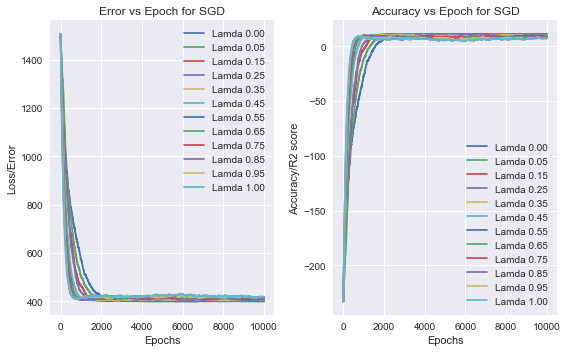

Time taken is:  17.788169860839844


In [16]:
printmodel(meth="ridge_sgd",beg=1,end=1,printerror=True)

### Surface Plots

In [18]:
def plotsuf(degree=2,meth="lasso_gd",coeff=0):
    start=time.time()
    print("Polynomial of degree",degree)
    print("Method:",meth)
    print("Regularization Parameter:",coeff)
    X,y=poly_model(degree,df)
    X_train,X_test,X_valid,y_train,y_valid,y_test=feature_scaling(X,y)
    
    if meth=="lasso_gd":
        wt,error,acc,rmsev=lasso_gd(coeff,X_train,y_train)
    elif meth=="lasso_sgd":
        wt,error,acc,rmsev=lasso_sgd(coeff,X_train,y_train)
    elif meth=="ridge_gd":
        wt,error,acc,rmsev=ridge_gd(coeff,X_train,y_train)
    else:
        wt,error,acc,rmsev=ridge_sgd(coeff,X_train,y_train)
    acc=r2_score(y_train,X_train@wt)
    rmsev=rmse(wt,X_train,y_train)
    print("Weights:",wt)
    print("Training Accuracy:",acc,"Validation Accuracy:",r2_score(y_valid,X_valid@wt),"Testing Accuracy:",r2_score(y_test,X_test@wt))
    print("Training RMSE:",rmsev,"Validation RMSE:",rmse(wt,X_valid,y_valid),"Testing RMSE:",rmse(wt,X_test,y_test),"\n")
        
    X1=X_train[0:,1]
    X2=X_train[0:,2]
    X1,X2=np.meshgrid(X1,X2)
    X1=X1.flatten()
    X2=X2.flatten()
    matr=np.array(np.vstack((X1,X2)).T,dtype='float')
    poly=PolynomialFeatures(degree)
    data=poly.fit_transform(matr)
    Z=data@wt
    fig=plt.figure(figsize=(6,6))
    axes=fig.gca(projection='3d')
    axes.set_title("Polynomial of degree {}".format(degree))
    axes.set_xlabel("AGE",y=5)
    axes.set_ylabel("BMI",y=5)
    axes.set_zlabel("CHARGES",y=5)
    axes.scatter3D(X_train[0:,1],X_train[0:,2],y_train,label="Training data")
    axes.scatter3D(X_test[0:,1],X_test[0:,2],y_test,label="Testing data")
    axes.plot_trisurf(X1,X2,Z.flatten(),cmap="rainbow")
    plt.legend()
    plt.show()
    end=time.time()
    print("Time taken is: ",(end-start))

Polynomial of degree 1
Method: lasso_gd
Regularization Parameter: 0
Weights: [-0.01410759  0.27365754  0.16333593]
Training Accuracy: 11.50524514920267 Validation Accuracy: 10.175822283635815 Testing Accuracy: 14.227665539636213
Training RMSE: 0.9242369318025938 Validation RMSE: 0.9939751540672602 Testing RMSE: 0.935949577560339 



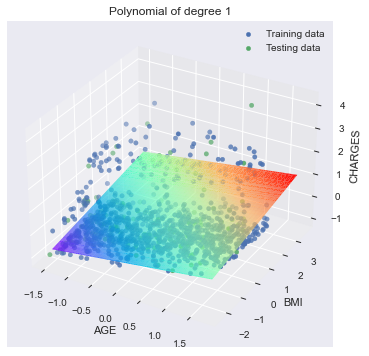

Time taken is:  8.268505096435547


In [19]:
plotsuf(degree=1,meth="lasso_gd",coeff=0)

### Getting Features for different degree Polynomials

Degree: 1, Features: 3
Degree: 2, Features: 6
Degree: 3, Features: 10
Degree: 4, Features: 15
Degree: 5, Features: 21
Degree: 6, Features: 28
Degree: 7, Features: 36
Degree: 8, Features: 45
Degree: 9, Features: 55
Degree: 10, Features: 66


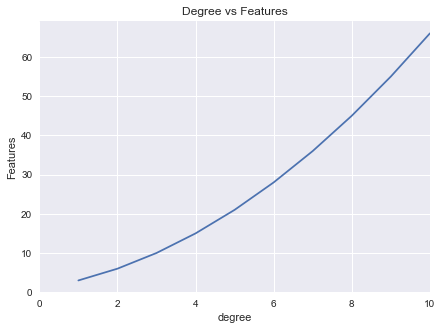

In [11]:
num_features=[]
degress = [i for i in range(1, 11)]
for d in degress:
    X,y=poly_model(d,df)
    num_features.append(X.shape[1]+1)
    print('Degree: %d, Features: %d' % (d, X.shape[1]+1))
fig=plt.figure(figsize=(7,5))
plt.title("Degree vs Features")
plt.xlabel("degree")
plt.ylabel("Features")
plt.xlim(0,10)
plt.plot(degress, num_features)
plt.show()